In [4]:
#!conda install -c conda-forge -c anaconda -y pygraphviz networkx
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [89]:
import numpy as np

class JobGenerator:
    def __init__(self, profiles):
        self.graph = nx.DiGraph()
        self.job_count = 0
        self.profiles = profiles
        
    def add_job(self, profile_name):
        self.graph.add_node(self.job_count, profile=profile_name)
        self.job_count += 1
        return self.job_count - 1  # Return the index of the added job

    def add_dependency(self, source, target):
        self.graph.add_edge(source, target)
        
    def generate_jobs(self, num_jobs, high_load_frequency, dependency_prob=0.3, high_load_dependency_prob=0.7):
        profile_types = list(self.profiles.keys())
        
        for _ in range(num_jobs):
            # Determine how many jobs are created at this point using a Poisson distribution
            n_jobs_now = np.random.poisson(lam=high_load_frequency)
            
            starting_job = self.job_count
            
            # Create the jobs now
            random_profiles = np.random.choice(profile_types, n_jobs_now)
            for p in random_profiles:
                self.add_job(p)
                
            # Adjust dependency probability for high load points
            current_dependency_prob = dependency_prob
            if n_jobs_now > 2:  # For example, consider it a high load point if more than 2 jobs are generated at once
                current_dependency_prob = high_load_dependency_prob
                
            # Add dependencies based on the defined probability
            for job in range(starting_job, self.job_count - 1):
                if np.random.rand() < current_dependency_prob:  
                    if self.graph.nodes[job]['profile'] != self.graph.nodes[job + 1]['profile']:
                        self.add_dependency(job, job + 1)
                        
            # Add cross-dependencies for high load points
            if n_jobs_now > 2:
                cross_dependency_job = self.add_job(np.random.choice(profile_types))
                for job in range(starting_job, self.job_count - 1):
                    if np.random.rand() < high_load_dependency_prob:
                        self.add_dependency(job, cross_dependency_job)
                
        return self.graph

In [91]:
from IPython.display import Image

def visualize_with_dot(graph):
    A = nx.nx_agraph.to_agraph(graph)
    A.layout(prog='dot')
    A.draw('temp.png')  # Save the visualization in a temporary file
    return Image(filename='temp.png')  # Display the saved image

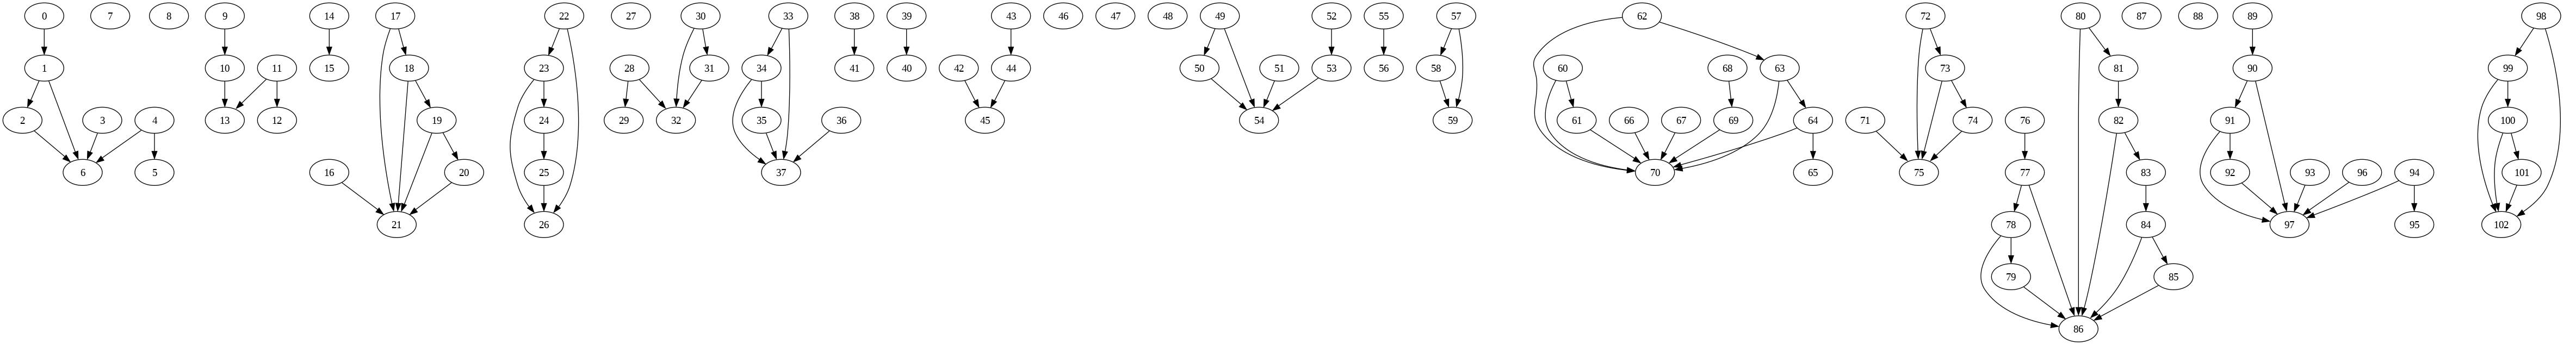

In [93]:
with open('profiles.json', 'r') as file:
    profiles = json.load(file)

job_gen = JobGenerator(profiles)
job_graph = job_gen.generate_jobs(num_jobs=20, high_load_frequency=5)
visualize_with_dot(job_graph)

In [94]:
# Convert NetworkX graph to pygraphviz graph for visualization
A = nx.nx_agraph.to_agraph(job_graph)

# Customize the graph's properties and node attributes
A.layout(prog="dot")
for node in A.nodes():
    node.attr['label'] = f"Job {node}\n({job_graph.nodes[int(node)]['profile']})"
    node.attr['shape'] = 'box'
    node.attr['style'] = 'rounded, filled'
    node.attr['color'] = 'skyblue'

A.draw("output_dag.png", prog="dot")

# Generating jobs
We generate jobs using the DAG

In [95]:
import json
import numpy as np

def generate_jobs_json(graph, profiles, output_path):
    data = {
        "command": "Generated in Jupyter Notebook",
        "date": str(np.datetime64('now')),
        "description": "this workload had been automatically generated",
        "profiles_description": "Randomly generated profiles",
        "profiles": profiles
    }

    # Determining the maximum number of resources used by any job in the profiles
    data["nb_res"] = max([profile.get('np', 1) for profile in profiles.values()])

    jobs = []

    for node in graph.nodes():
        job_info = graph.nodes[node]
        
        # If the node has dependencies, use the subtime of the first predecessor
        # If not, generate a new subtime
        predecessors = list(graph.predecessors(node))
        if predecessors:
            subtime = next((job["subtime"] for job in jobs if job["id"] == predecessors[0]), np.random.uniform(1, 20))
        else:
            subtime = np.random.uniform(1, 20)
        
        job = {
            "id": node,
            "profile": job_info['profile'],
            "res": 1,  # you might want to adjust this based on your needs
            "subtime": subtime,
            "walltime": np.random.uniform(1, 10*60)  # 10 minutes at max
        }

        # Handling dependencies
        if predecessors:
            job['dependencies'] = predecessors

        jobs.append(job)
        
    data["jobs"] = jobs

    with open(output_path, 'w') as file:
        json.dump(data, file, indent=4)

In [96]:
# Example usage:
with open('profiles.json', 'r') as file:
    profiles = json.load(file)

generate_jobs_json(job_graph, profiles, "workload0.json")

# Gráficos sobre tareas generadas

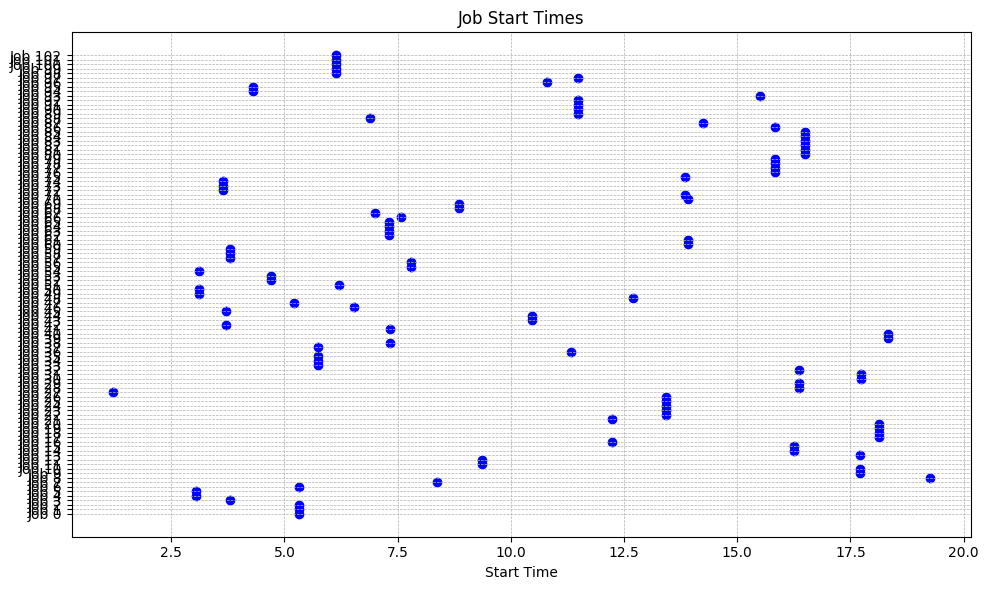

In [97]:
import matplotlib.pyplot as plt
import json

def plot_gantt_chart(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    # Extrayendo información de los trabajos
    jobs = data['jobs']
    job_ids = [job['id'] for job in jobs]
    start_times = [job['subtime'] for job in jobs]
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(start_times, job_ids, color='blue', marker='o')
    ax.set_yticks(job_ids)
    ax.set_yticklabels(['Job ' + str(i) for i in job_ids])
    ax.set_xlabel('Start Time')
    ax.set_title('Job Start Times')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# Usar la función para mostrar el gráfico de inicio de las tareas
plot_gantt_chart('workload0.json')

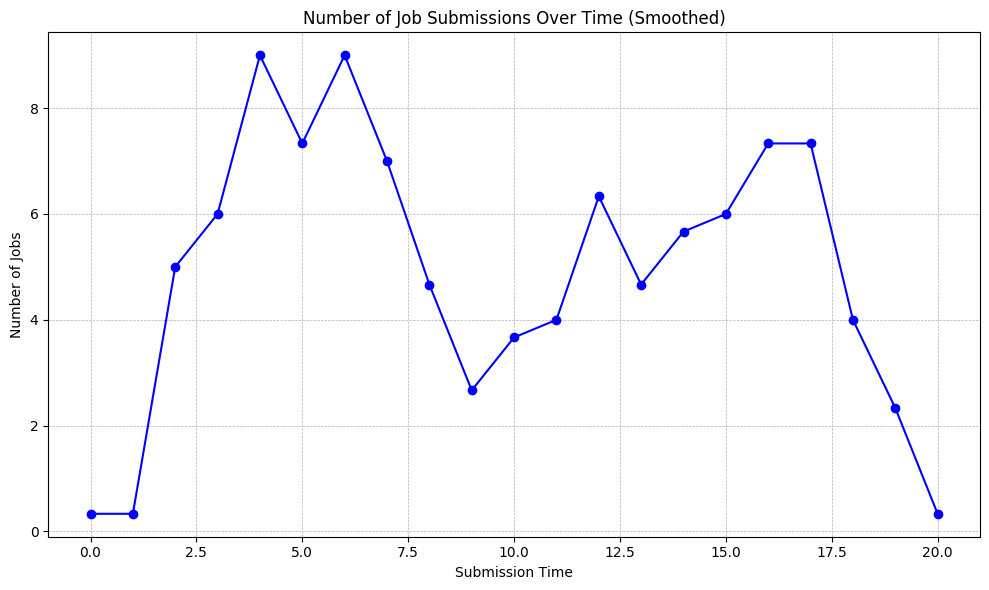

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Load the generated jobs from the JSON
with open("workload0.json", "r") as file:
    workload_data = json.load(file)

# Extract subtimes
subtimes = [job["subtime"] for job in workload_data["jobs"]]

# Create a histogram of job counts for intervals of time
time_bins = np.arange(0, max(subtimes) + 2, 1)  # Assuming each bin is of size 1. Adjust if needed.
job_counts, _ = np.histogram(subtimes, bins=time_bins)

# Compute the rolling average
window_size = 3  # This is the number of points considered for the moving average. Adjust as needed.
smoothed_job_counts = np.convolve(job_counts, np.ones(window_size)/window_size, mode='same')

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(time_bins[:-1], smoothed_job_counts, marker='o', linestyle='-', color='b')
plt.title("Number of Job Submissions Over Time (Smoothed)")
plt.xlabel("Submission Time")
plt.ylabel("Number of Jobs")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


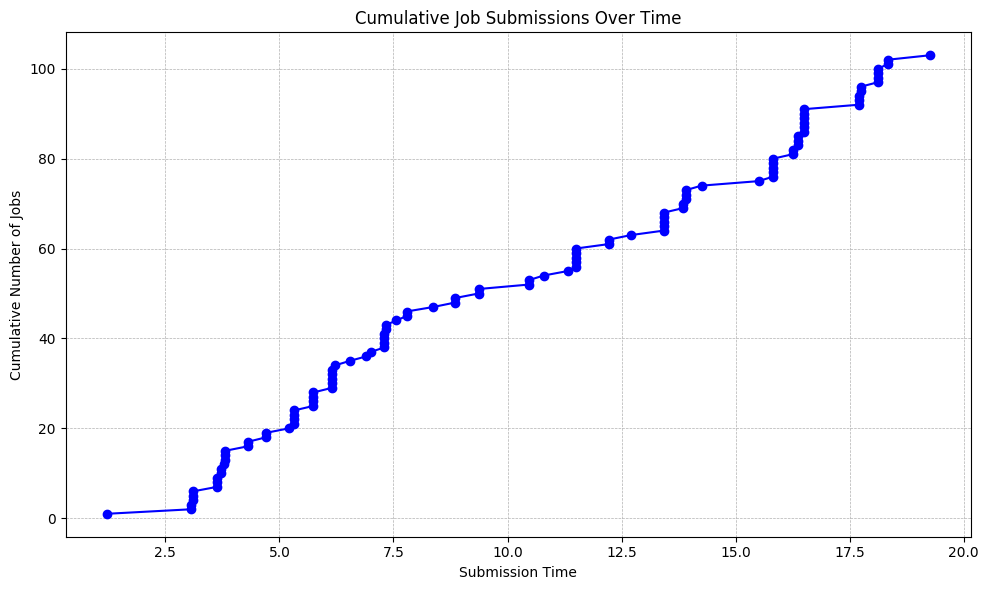

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Load the generated jobs from the JSON
with open("workload0.json", "r") as file:
    workload_data = json.load(file)

# Extract subtimes
subtimes = [job["subtime"] for job in workload_data["jobs"]]

# Sorting subtimes
sorted_subtimes = np.sort(subtimes)

# Create a cumulative count of jobs for each unique subtime
cumulative_counts = np.arange(1, len(sorted_subtimes) + 1)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_subtimes, cumulative_counts, marker='o', linestyle='-', color='b')
plt.title("Cumulative Job Submissions Over Time")
plt.xlabel("Submission Time")
plt.ylabel("Cumulative Number of Jobs")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()